TT

In [91]:

library(datasets)
library(catdata)
library(dslabs)
library(mvtnorm)
library(patchwork)
library(paletteer)
library(tidyverse)


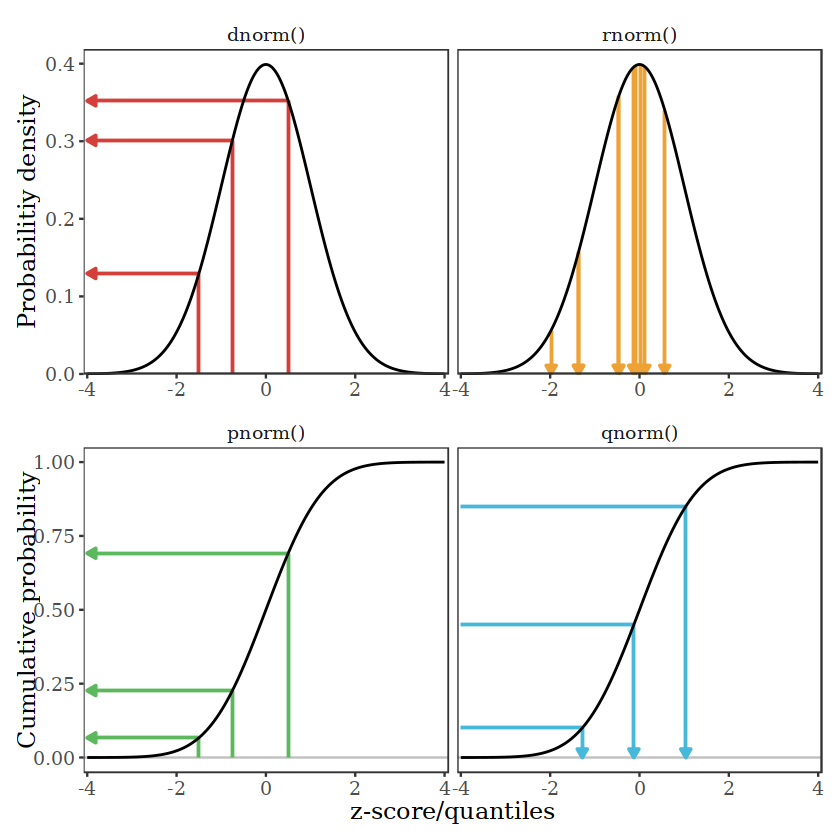

In [92]:

# I comandi qui sotto e fino alla fine di questo chunk del codice servono solo a far vedere cosa
# calcolano queste funzioni nel caso di una normale standard.
# Lanciateli e vedete la figura che producono

z_scores <- seq(-4, 4, by = 0.01)
mu <- 0
sd <- 1


#Functions
##Using `dnorm` and `pnorm` to setup the "skeleton" of related plots.
normal_dists <- list(`dnorm()` = ~ dnorm(., mu, sd),
`rnorm()` = ~ dnorm(., mu, sd),
`pnorm()` = ~ pnorm(., mu, sd),
`qnorm()` = ~ pnorm(., mu, sd))

##Apply functions to data and parameter combinations
df <- tibble(z_scores, mu, sd) %>%
mutate_at(.vars = vars(z_scores), .funs = normal_dists) %>%
#"Lengthen" the data
pivot_longer(cols = -c(z_scores, mu, sd), names_to = "func",
  values_to = "prob") %>%
#Categorize based on shape of distribution -- need to split up the dataframe
# for plotting later.
mutate(distribution = ifelse(func == "pnorm()" | func == "qnorm()",
  "Cumulative probability", "Probability density"))

##Split up the data into different pieces that can then be added to a plot.
###Probabilitiy density distrubitions
df_pdf <- df %>%
filter(distribution == "Probability density") %>%
rename(`Probabilitiy density` = prob)

###Cumulative density distributions
df_cdf <- df %>%
filter(distribution == "Cumulative probability") %>%
rename(`Cumulative probability` = prob)

###dnorm segments
#Need to make lines that represent examples of how values are mapped -- there
# is probably a better way to do this, but quick and dirty is fine for now.
df_dnorm <- tibble(z_start.line_1 = c(-1.5, -0.75, 0.5),
pd_start.line_1 = 0) %>%
mutate(z_end.line_1 = z_start.line_1,
  pd_end.line_1 = dnorm(z_end.line_1, mu, sd),
  z_start.line_2 = z_end.line_1,
  pd_start.line_2 = pd_end.line_1,
  z_end.line_2 = min(z_scores),
  pd_end.line_2 = pd_start.line_2,
  id = 1:n()) %>%
pivot_longer(-id) %>%
separate(name, into = c("source", "line"), sep = "\\.") %>%
pivot_wider(id_cols = c(id, line), names_from = source) %>%
mutate(func = "dnorm()",
  size = ifelse(line == "line_1", 0, 0.03))

###rnorm segments
#Make it reproducible
set.seed(20200209)
df_rnorm <- tibble(z_start = rnorm(10, mu, sd)) %>%
mutate(pd_start = dnorm(z_start, mu, sd),
  z_end = z_start,
  pd_end = 0,
  func = "rnorm()")

###pnorm segments
df_pnorm <- tibble(z_start.line_1 = c(-1.5, -0.75, 0.5),
pd_start.line_1 = 0) %>%
mutate(z_end.line_1 = z_start.line_1,
  pd_end.line_1 = pnorm(z_end.line_1, mu, sd),
  z_start.line_2 = z_end.line_1,
  pd_start.line_2 = pd_end.line_1,
  z_end.line_2 = min(z_scores),
  pd_end.line_2 = pd_start.line_2,
  id = 1:n()) %>%
pivot_longer(-id) %>%
separate(name, into = c("source", "line"), sep = "\\.") %>%
pivot_wider(id_cols = c(id, line), names_from = source) %>%
mutate(func = "pnorm()",
  size = ifelse(line == "line_1", 0, 0.03))

###qnorm segments
df_qnorm <- tibble(z_start.line_1 = min(z_scores),
pd_start.line_1 = c(0.1, 0.45, 0.85)) %>%
mutate(z_end.line_1 = qnorm(pd_start.line_1),
  pd_end.line_1 = pd_start.line_1,
  z_start.line_2 = z_end.line_1,
  pd_start.line_2 = pd_end.line_1,
  z_end.line_2 = z_end.line_1,
  pd_end.line_2 = 0,
  id = 1:n()) %>%
pivot_longer(-id) %>%
separate(name, into = c("source", "line"), sep = "\\.") %>%
pivot_wider(id_cols = c(id, line), names_from = source) %>%
mutate(func = "qnorm()",
  size = ifelse(line == "line_1", 0, 0.03))

  cp <- paletteer_d("ggsci::default_locuszoom", 4, )
  names(cp) <- c("dnorm()", "rnorm()", "pnorm()", "qnorm()")

  ##Probabilitiy density
  p_pdf <- df_pdf %>%
    ggplot(aes(z_scores, `Probabilitiy density`)) +
    geom_segment(data = df_dnorm,
      aes(z_start, pd_start, xend = z_end, yend = pd_end),
      arrow = arrow(length = unit(df_dnorm$size, "npc"), type = "closed"),
      size = 0.8, color = cp["dnorm()"]) +
    geom_segment(data = df_rnorm,
      aes(z_start, pd_start, xend = z_end, yend = pd_end),
      arrow = arrow(length = unit(0.03, "npc"), type = "closed"),
      size = 0.8, color = cp["rnorm()"]) +
    geom_line(size = 0.6) +
    facet_wrap(~ func, nrow = 1) +
    theme_bw() +
    theme(panel.grid = element_blank(),
      axis.title.x = element_blank(),
      strip.background = element_blank(),
      text = element_text(family = "serif", size = 14)) +
    scale_y_continuous(expand = expand_scale(c(0, 0.05))) +
    scale_x_continuous(expand = c(0.01, 0))

  ##Cumulative probability
  p_cdf <- df_cdf %>%
    ggplot(aes(z_scores, `Cumulative probability`)) +
    geom_hline(yintercept = 0, color = "grey") +
    geom_segment(data = df_pnorm,
      aes(z_start, pd_start, xend = z_end, yend = pd_end),
      arrow = arrow(length = unit(df_dnorm$size, "npc"), type = "closed"),
      size = 0.8, color = cp["pnorm()"]) +
    geom_segment(data = df_qnorm,
      aes(z_start, pd_start, xend = z_end, yend = pd_end),
      arrow = arrow(length = unit(df_qnorm$size, "npc"), type = "closed"),
      size = 0.8, color = cp["qnorm()"]) +
    geom_line(size = 0.6) +
    facet_wrap(~ func, nrow = 1) +
    labs(x = "z-score/quantiles") +
    theme_bw() +
    theme(panel.grid = element_blank(),
      strip.background = element_blank(),
      text = element_text(family = "serif", size = 14)) +
    scale_x_continuous(expand = c(0.01, 0))

  ##Combine the plots
  p_pdf + p_cdf + plot_layout(ncol = 1)



Simulazione da un'uniforme

In [93]:
r_unif01 = function(n, seed, m=100, c=2, a=4)
{
    if( (c<0)  |  (c>m))
    {
        stop("errore in c")
    }
    if( (a<=0)  |  (a>=m))
    {
        stop("errore in a")
    }
    ret = rep(NA, n)
    pred_val = seed
    for(i in 1:n)
    {
        ret[i] = (a*pred_val +c) %% m
        pred_val = ret[i]
    }
    return(ret/m)
}






In [94]:
x = r_unif01(n= 10000, seed = 0, m=1000, c=3, a=5)

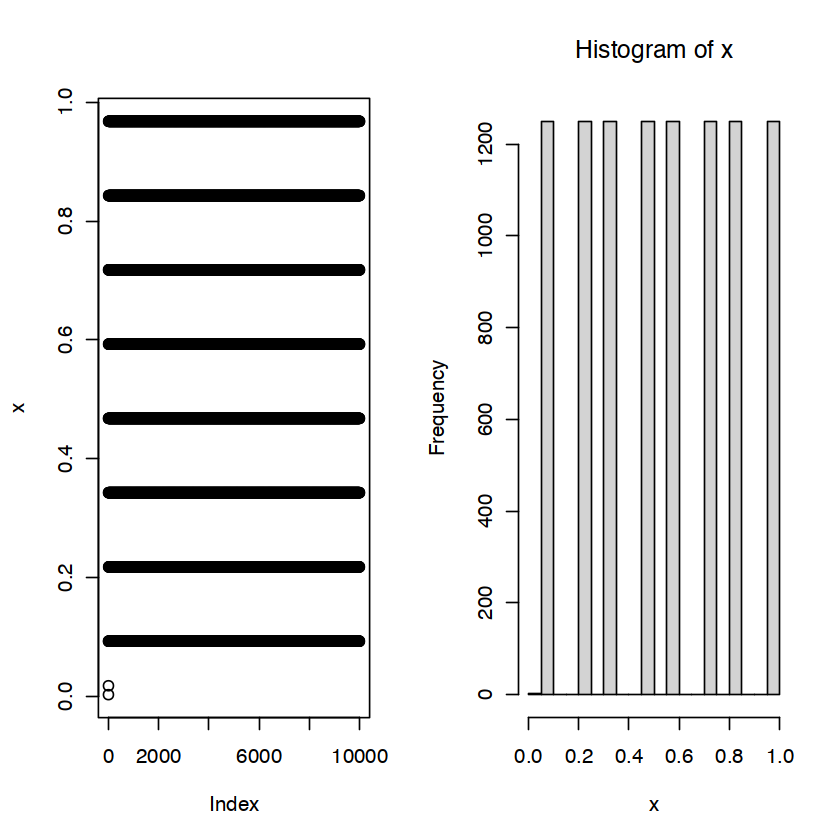

In [95]:
par(mfrow=c(1,2))
plot(x)
hist(x)

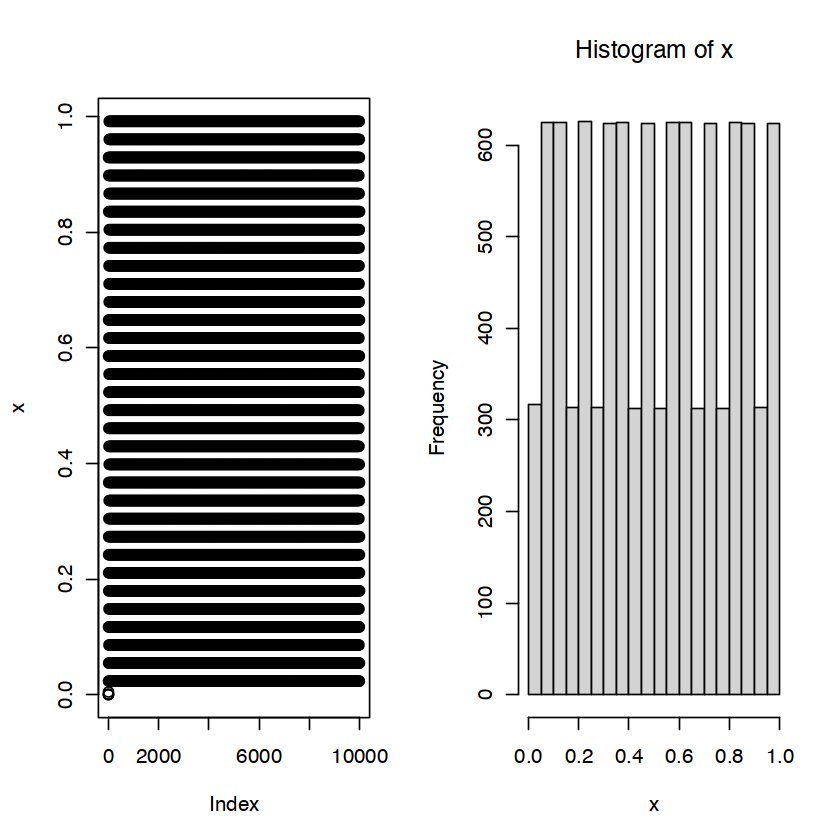

In [96]:
x = r_unif01(n= 10000, seed = 0, m=100000, c=3, a=5)
par(mfrow=c(1,2))
plot(x)
hist(x)

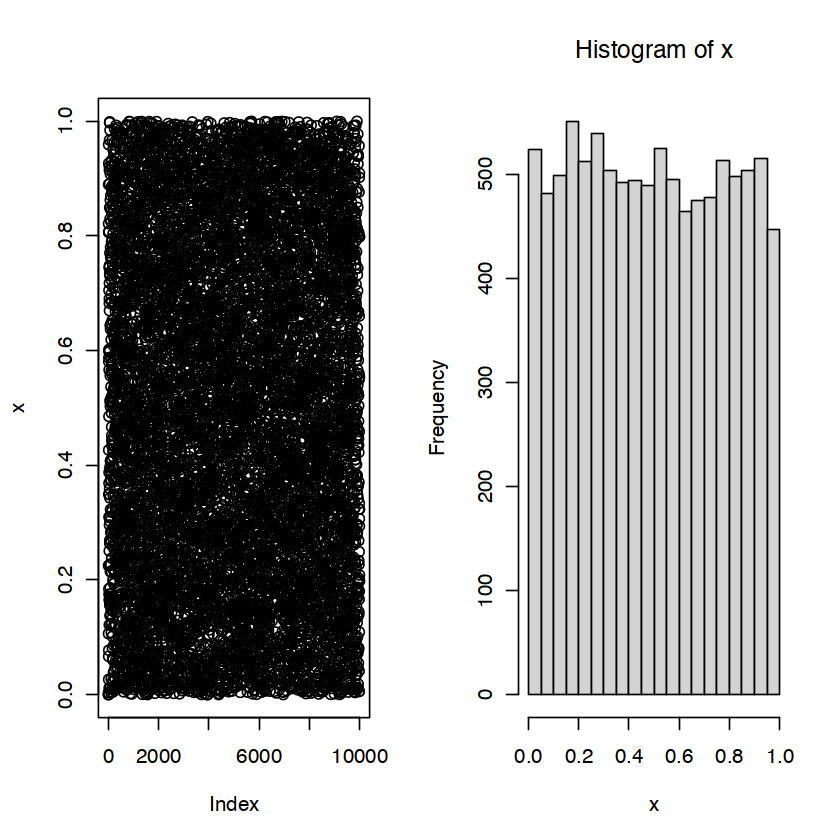

In [97]:
x = r_unif01(n= 10000, seed = 0, m=1000000, c=3.7, a=30.3)
par(mfrow=c(1,2))
plot(x)
hist(x)

# Monte Carlo
Voglio calcolare 
$$
E(X^2) = \int x^2f(x) dx
$$
 con $X \sim G(1,1)$.
 Lo stimiamo con 
 $$
\frac{\sum x_i^2}{n}
 $$

In [98]:
n = 100000 
x = rgamma(n, 1,1)
x2 = x^2


In [99]:
sum_x2 = cumsum(x2)

mean_x2 = rep(NA, n)
for(i in 1:n)
{
    mean_x2[i] = sum_x2[i] / i
}


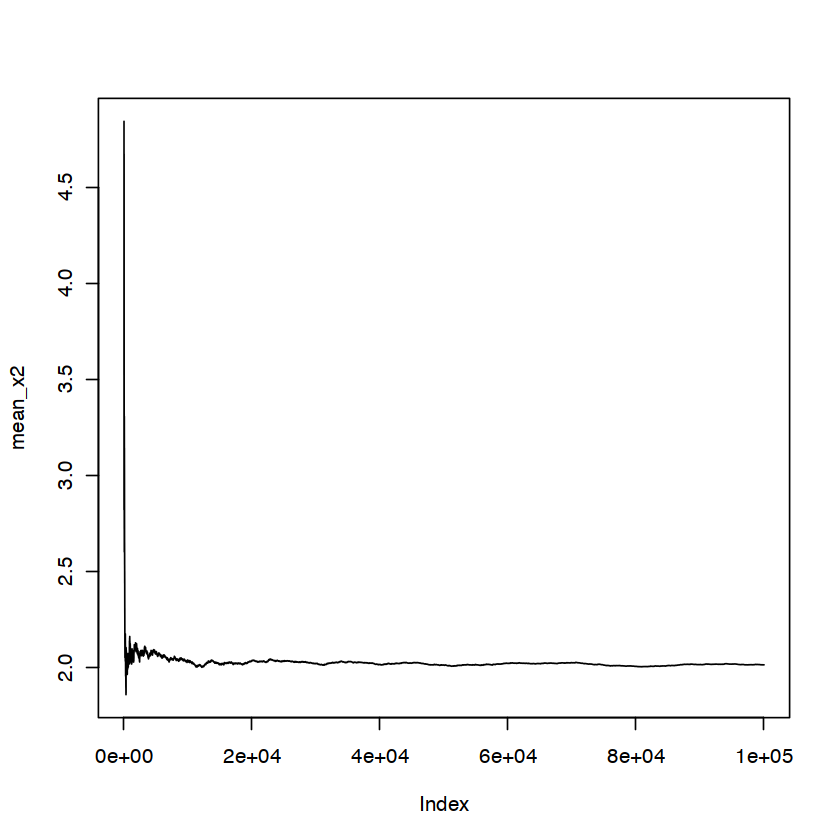

In [100]:
plot(mean_x2, type="l")

Voglio vedere quanto lo stimatore della media è variabile

In [101]:
n = 100000
x = rgamma(n, 1,1)
sum_x = cumsum(x)

mean_x = rep(NA, n)
for(i in 1:n)
{
    mean_x[i] = sum_x[i] / i
}


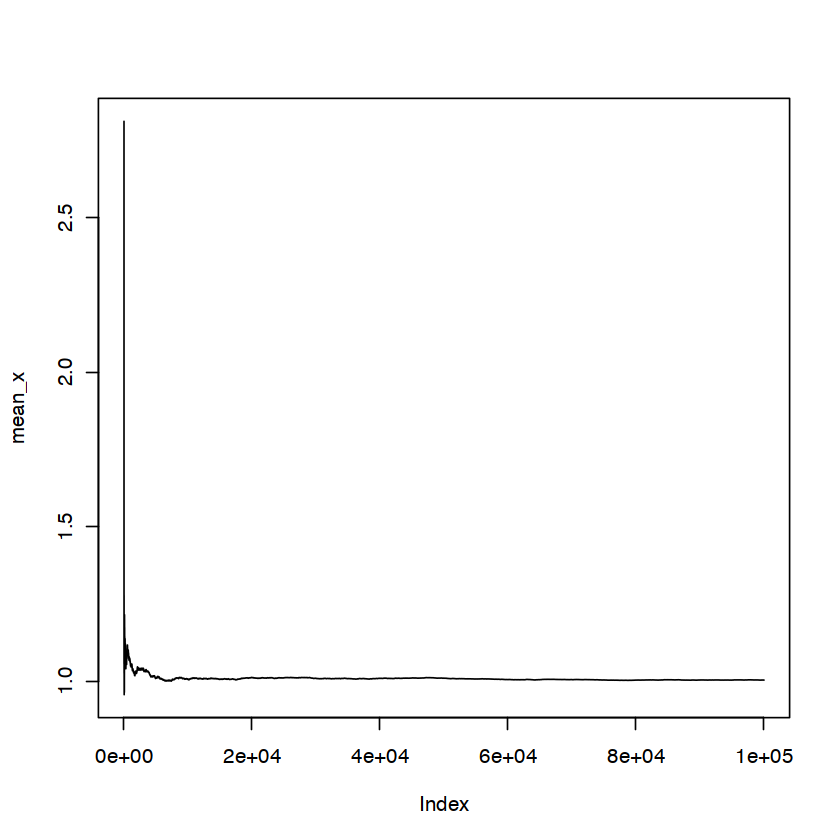

In [102]:
plot(mean_x, type="l")

In [119]:
n_sim = 500
n = 10000
mean_mat_x = matrix(NA, nrow=n, ncol=n_sim)
for(isim in 1:n_sim)
{
    x = rgamma(n, 1,1)
    sum_x = cumsum(x)
    for(i in 1:n)
    {
        mean_mat_x[i, isim] = sum_x[i] / i
    }
}

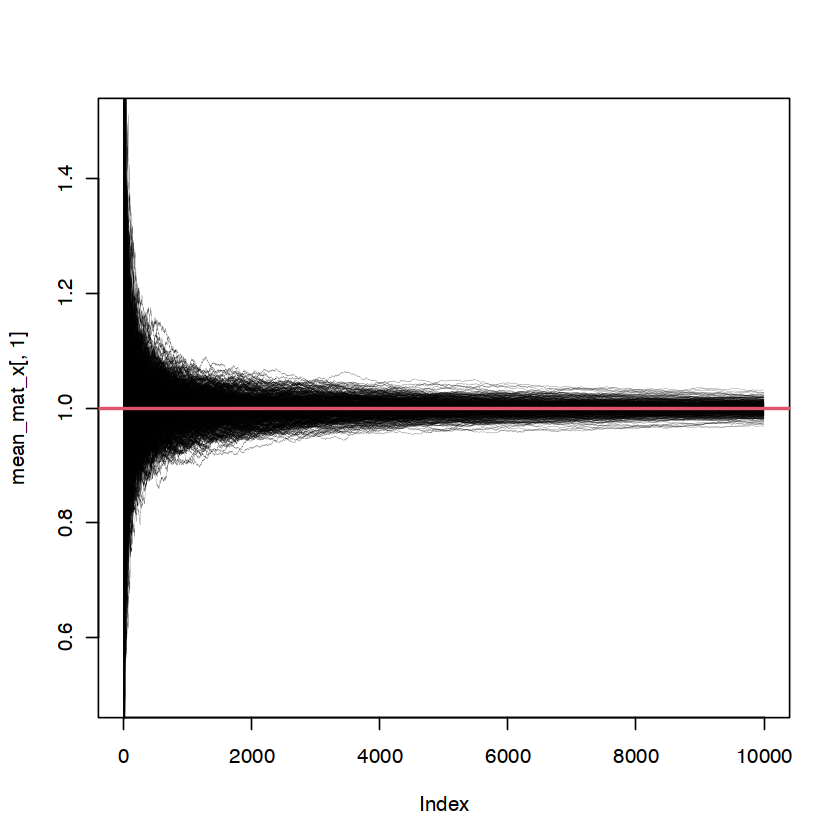

In [127]:
plot(mean_mat_x[,1], type="l", ylim=c(0.5,1.5), lwd=0.1)
for(isim in 2:n_sim)
{
    lines(mean_mat_x[,isim], lwd=0.1)
}
abline(h = 1, col=2, lwd = 2)



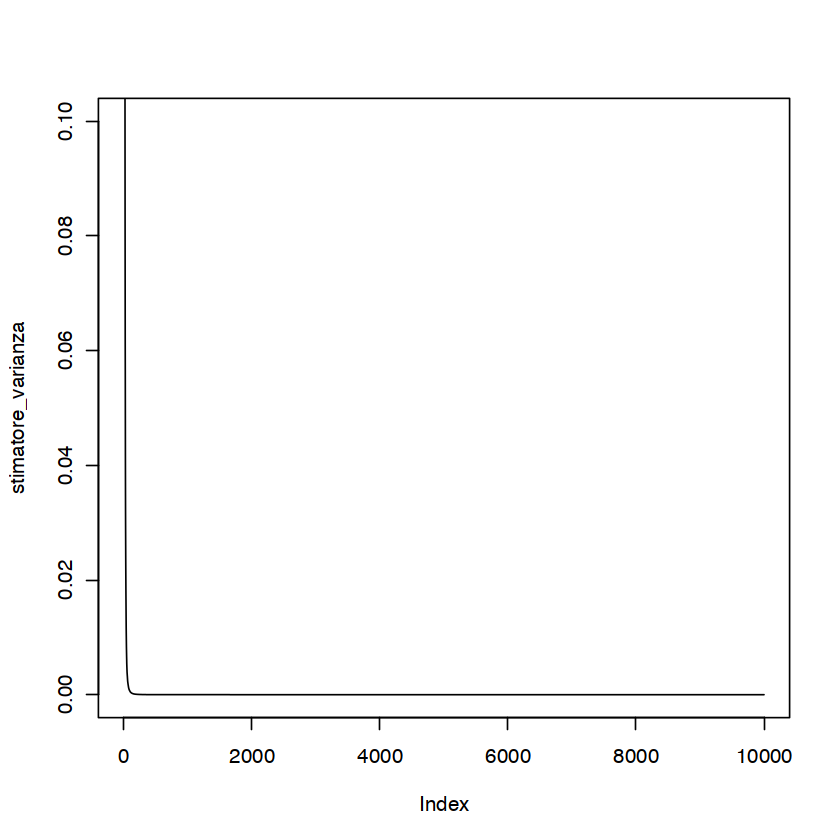

In [121]:
# varianza

stimatore_varianza = rep(NA, n)
for(irow in 1:n)
{
    stimatore_varianza[irow] = sum((mean_mat_x[irow, ] -mean(mean_mat_x[irow, ]))^2)/irow^2
}

plot(stimatore_varianza, type="l", ylim=c(0,0.1))


Il teorema del limite centrale dice che
$$
Z_i = \frac{\bar{X}_i-E(\bar{X}_i)}{\sqrt{Var(\bar{X}_i)}} \approx N(0,1)
$$
se $X \sim G(1,1)$ allora $E(X_i) = 1$ e var $var(X_i) = 1$ quindi
$$
E(\bar{X}_i) = E(X)  \ \ \ \ \ \ Var(\bar{X}_i) = var(X_i)/i
$$



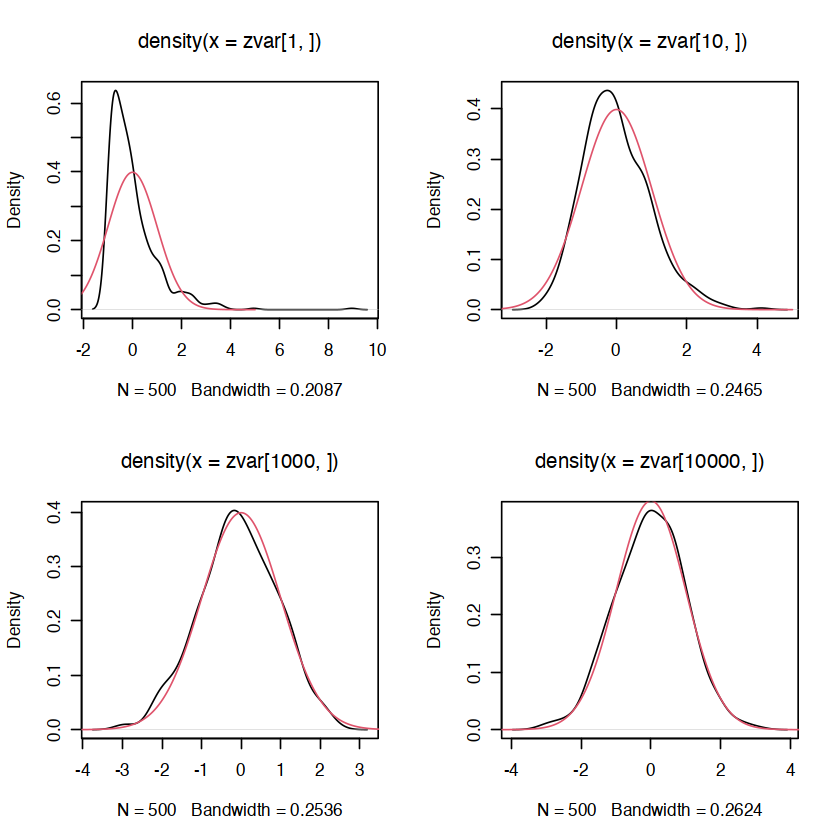

In [130]:
zvar = mean_mat_x
for(i in 1:n)
{
    zvar[i,] = (mean_mat_x[i,]-1)/sqrt(1/i)
}
xseq = seq(-5,5, by=0.01)
par(mfrow=c(2,2))
plot(density(zvar[1,]))
lines(xseq, dnorm(xseq), col=2)

plot(density(zvar[10,]))
lines(xseq, dnorm(xseq), col=2)

plot(density(zvar[1000,]))
lines(xseq, dnorm(xseq), col=2)

plot(density(zvar[10000,]))
lines(xseq, dnorm(xseq), col=2)


Calcoliamo la marginale
$$
f(x^*) = \int f(x|y)g(y)d y
$$
con $X \sim G(\exp(y),1)$ e $Y \sim \exp(\lambda)$

In [78]:
n = 100
lambda = 1
xstart = 1

y = rexp(n, lambda)
condizionata = rep(NA, n)
for(i in 1:n)
{
    condizionata[i] = dgamma(xstart, exp(y[i]), 1)
}

sum(condizionata)/n







[1] 0.2755747

In [89]:

n = 10
lambda = 1
xstar = seq(0.00001, 10, by = 0.01)
vec_marg = rep(NA, length(xstar))

y = rexp(n, lambda)
for(isim in 1:length(xstar))
{
    
    condizionata = rep(NA, n)
    for(i in 1:n)
    {
        condizionata[i] = dgamma(xstar[isim], exp(y[i]), 1)
    }

    vec_marg[isim] = sum(condizionata)/n
}

#





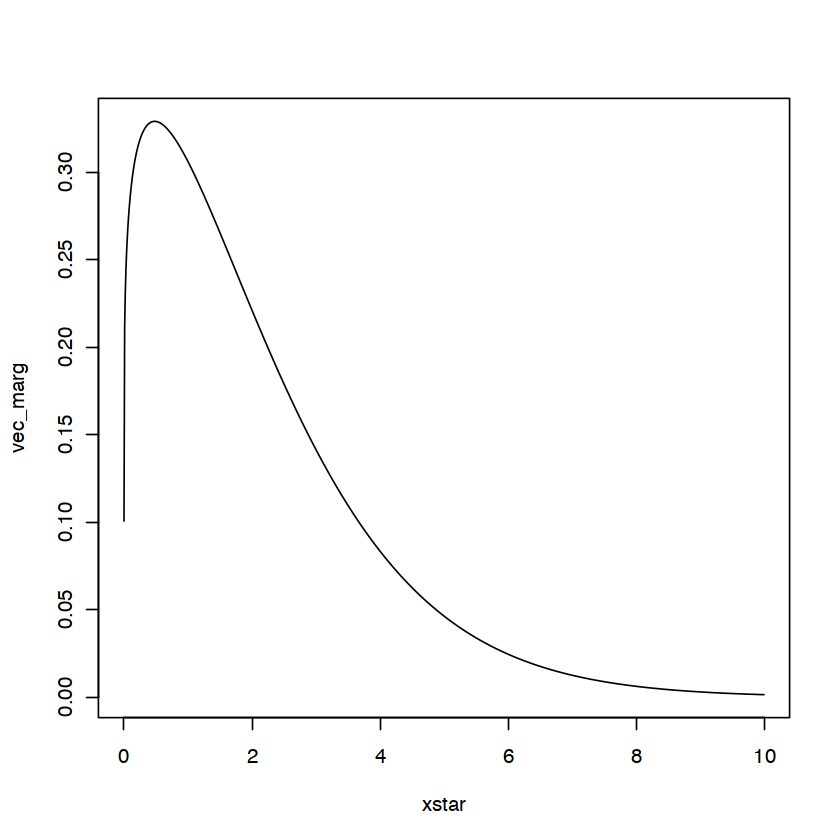

In [90]:
plot(xstar, vec_marg, type="l")